---
title: "Decision Trees"
author: "phonchi"
date: "11/14/2022"
format: 
  html:
    toc: true
    code-line-numbers: true
    code-tools: true
---

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math524/blob/master/static_files/presentations/Chapter_8_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math524/blob/master/static_files/presentations/Chapter_8_Lab.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br/>

## Setup

We first use classification trees  to analyze the `Carseats` data set.
In these data, `Sales` is a continuous variable, and so we begin by recoding it  as a binary variable.

In [ ]:
!pip install git+https://github.com/JakeColtman/bartpy.git -qq
!pip install xgboost -U -qq
!pip install lightgbm -U -qq
!pip install catboost -U -qq

     |████████████████████████████████| 255.9 MB 37 kB/s 
     |████████████████████████████████| 2.0 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 128 kB/s 


In [ ]:
!pip install mlxtend --upgrade --no-deps

     |████████████████████████████████| 1.3 MB 5.4 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
import pandas as pd
import numpy as np
import time

from sklearn import datasets
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor, StackingClassifier, VotingClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# Require extra installation
from bartpy.sklearnmodel import SklearnModel 
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

import graphviz 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## Fitting classification trees
The current data we have is of an organization who sells car seats, each row represents a region. Therefore for each region, the columns are - 

- **Sales**: unit sales in thousands
- **CompPrice**: price charged by competitor at each location
- **Income**: community income level in 1000s of dollars
- **Advertising**: local ad budget at each location in 1000s of dollars
- **Population**: regional pop in thousands
- **Price**: price for car seats at each site
- **ShelveLoc**: Bad, Good or Medium indicates quality of shelving location
- **Age**: age level of the population
- **Education**: ed level at location
- **Urban**: Yes/No
- **US**: Yes/No

The company wants to set up a busniess in some new region, we have the information of that region and want to predict what the sales would be. To make the model we will use this data as training data source.

We create a variable, called `High`, which takes on a value of `Yes` if the `Sales` variable exceeds $8$, and takes on a value of `No` otherwise.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Carseats = pd.read_csv('/content/drive/MyDrive/Lab/Data/Carseats.csv')

print(Carseats.shape)
# Check for missing values
assert Carseats.isnull().sum().sum() == 0

# Create binary variable High 1 if Sales > 8
Carseats['High'] = (Carseats['Sales'] > 8).astype(np.float64)

Carseats.head()


(400, 11)


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1.0
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,1.0
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,1.0
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,0.0
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,0.0


In [ ]:
predictors = Carseats.drop(["Sales","High"], axis=1).columns
X = pd.get_dummies(Carseats[predictors], drop_first=True)
y = Carseats["High"]

In [ ]:
X

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,138,73,11,276,120,42,17,0,0,1,1
1,111,48,16,260,83,65,10,1,0,1,1
2,113,35,10,269,80,59,12,0,1,1,1
3,117,100,4,466,97,55,14,0,1,1,1
4,141,64,3,340,128,38,13,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
395,138,108,17,203,128,33,14,1,0,1,1
396,139,23,3,37,120,55,11,0,1,0,1
397,162,26,12,368,159,40,18,0,1,1,1
398,100,79,7,284,95,50,12,0,0,1,1


The best found split may vary across different runs, even if `max_features=n_features`. That is the case, if the improvement of the criterion is identical for several splits and one split has to be selected at random. To obtain a deterministic behaviour during fitting, random_state

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [ ]:
clf_tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=1, criterion='entropy')
clf_tree.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5,
                       random_state=1)

One of the most attractive properties of trees is that they can be  graphically displayed. We use the `plot_tree()` function to display the tree structure, and the `export_text` function to display the node labels. The argument `feature_names` instructs `Python` to include the feature names for any predictors, rather than simply displaying a number.

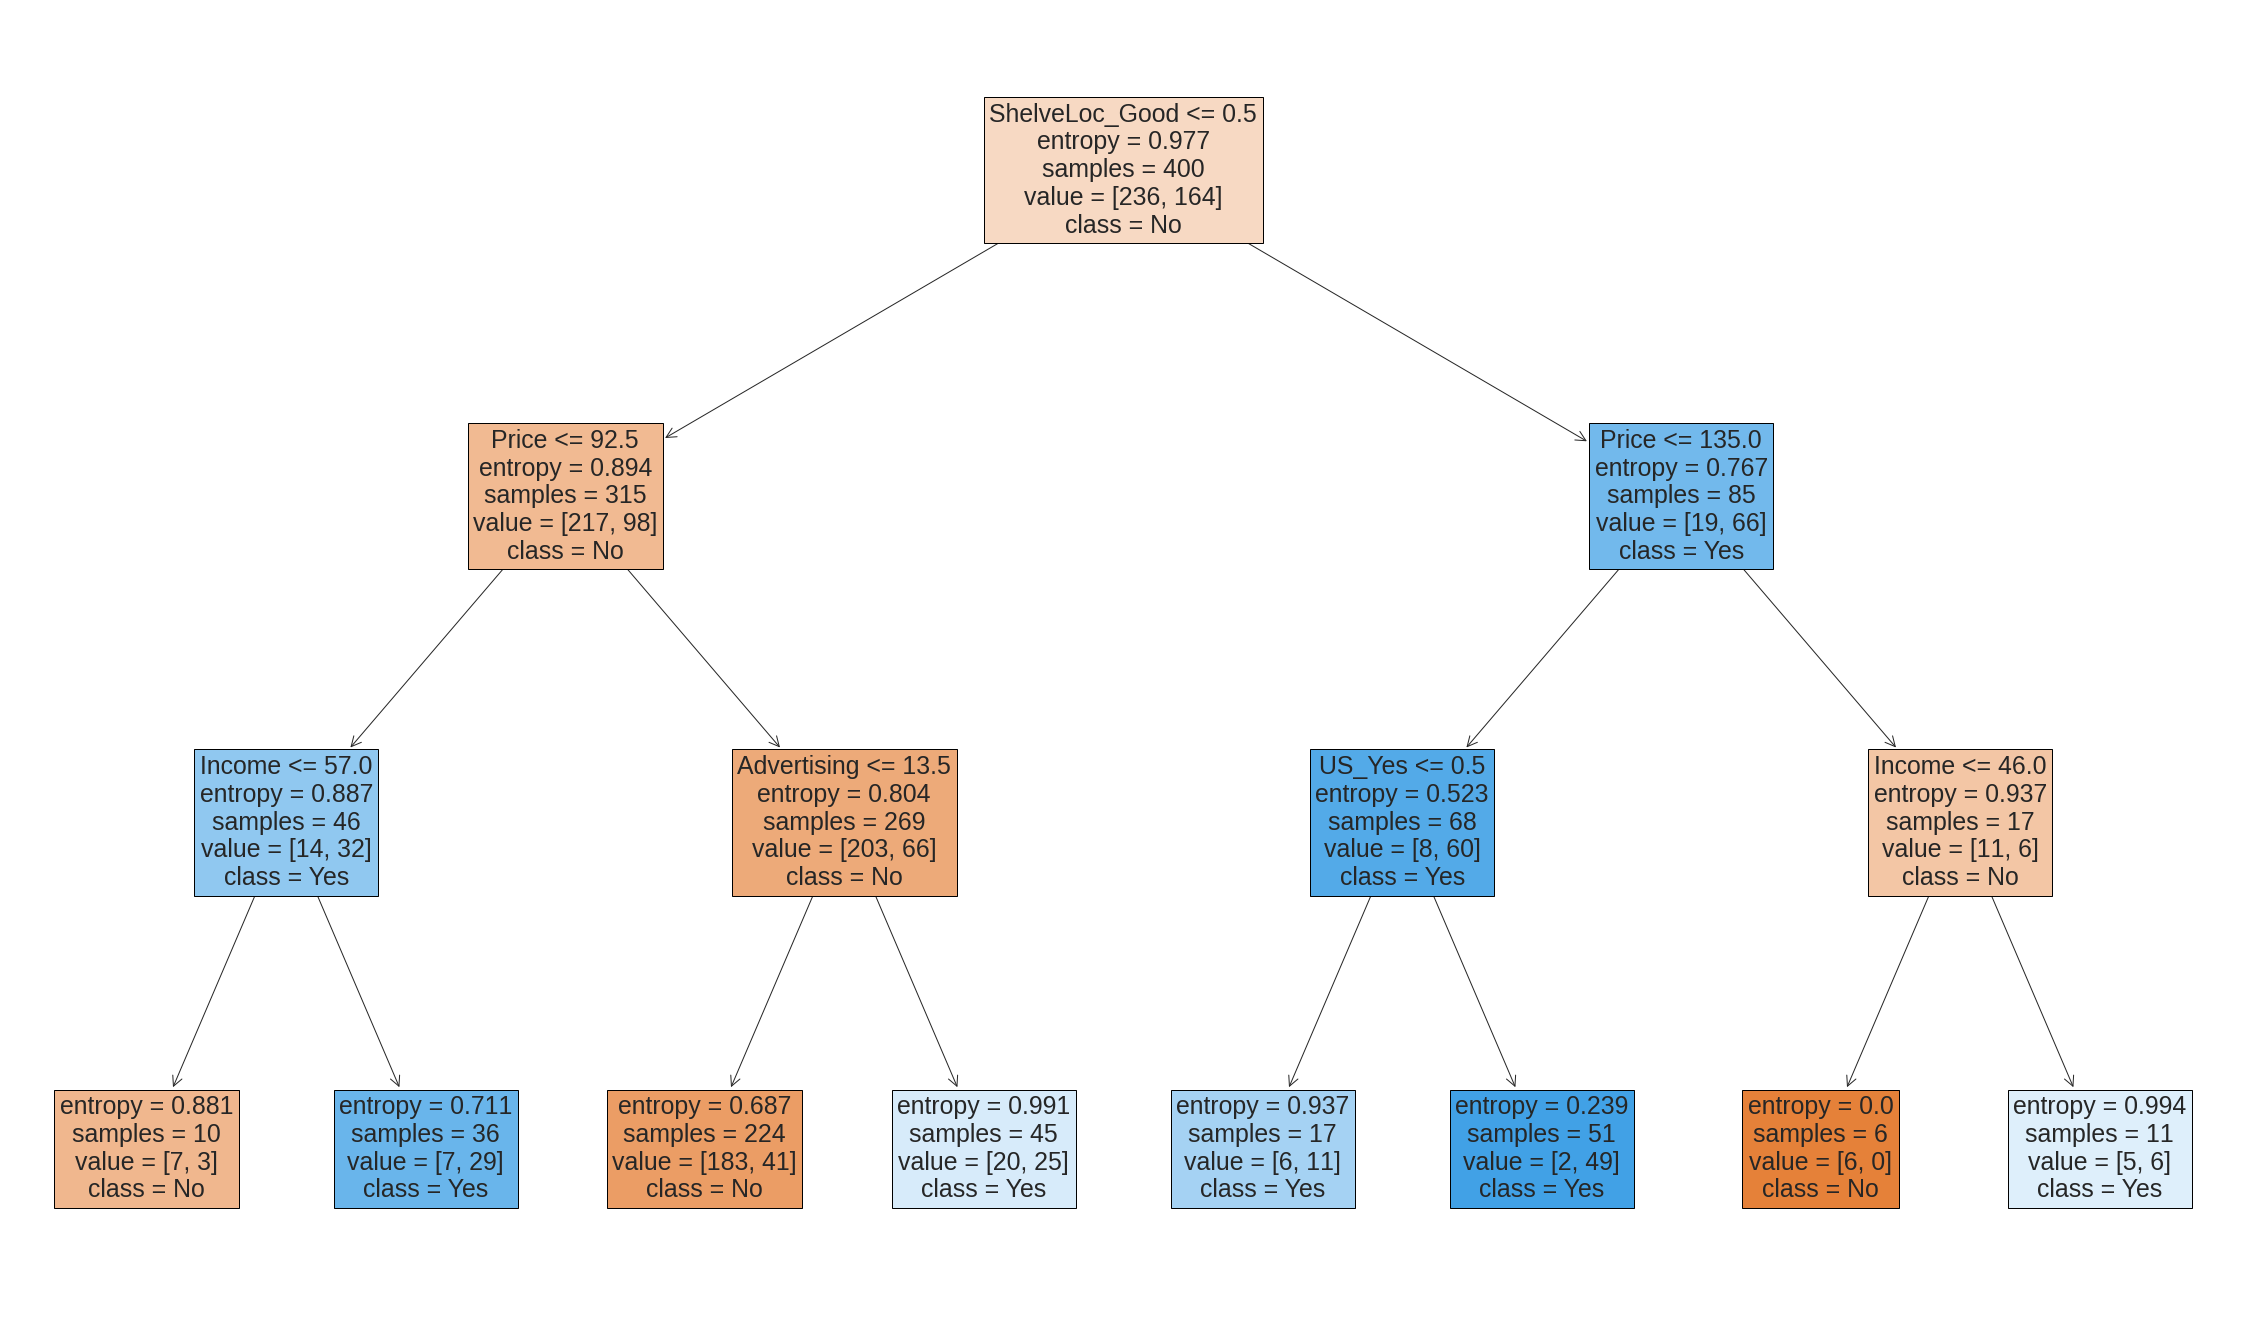

In [ ]:
plt.figure(figsize=(40,24))
tree.plot_tree(clf_tree, feature_names=X.columns,  
                    class_names=['No','Yes'],
                    filled=True)
plt.show()

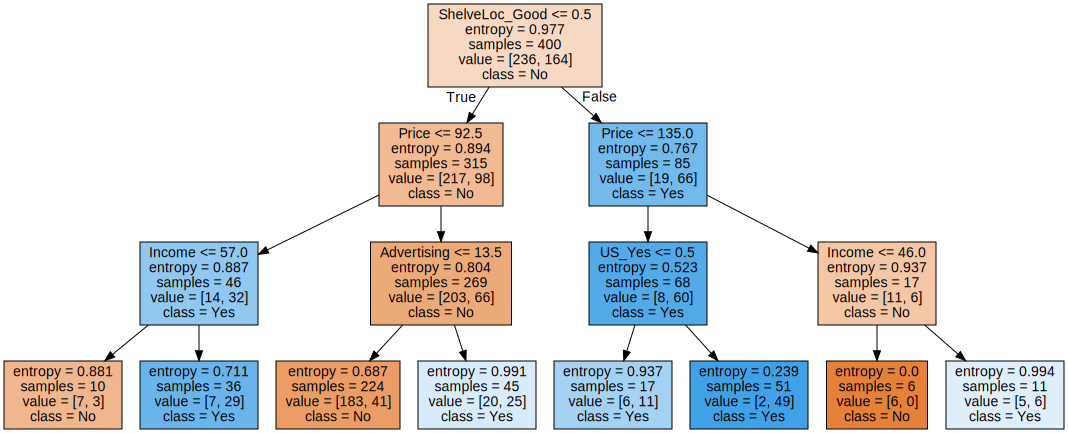

In [ ]:
dot_data = tree.export_graphviz(clf_tree, feature_names=X.columns,  
                    class_names=['No','Yes'],
                    filled=True, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("tree1")
graph 

In [ ]:
r = tree.export_text(clf_tree, feature_names=list(X.columns))
print(r)

|--- ShelveLoc_Good <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- class: 0.0
|   |   |--- Income >  57.00
|   |   |   |--- class: 1.0
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- class: 0.0
|   |   |--- Advertising >  13.50
|   |   |   |--- class: 1.0
|--- ShelveLoc_Good >  0.50
|   |--- Price <= 135.00
|   |   |--- US_Yes <= 0.50
|   |   |   |--- class: 1.0
|   |   |--- US_Yes >  0.50
|   |   |   |--- class: 1.0
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- class: 0.0
|   |   |--- Income >  46.00
|   |   |   |--- class: 1.0



The most important indicator of `Sales` appears to be shelving location, since the first branch differentiates `Good` locations from `Bad` and `Medium` locations.

For more information about understanding the structure and decision path [https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py).

In [ ]:
#clf_tree = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=1, criterion='entropy')
clf_tree = DecisionTreeClassifier(max_leaf_nodes=30, random_state=1, criterion='entropy')
clf_tree.fit(X, y)
clf_tree.score(X, y)

0.9375

We see that the training error rate is  $6.25\%$ when we set the `max_leaf_nodes` to 30. In order to properly evaluate the performance of a classification tree
on these data, we must estimate the test error rather than simply computing the training error. We split the observations into a training set and a test set, build the tree using the training set, and evaluate its performance on the test data. The `predict()` function can be used for this purpose. This approach leads to correct predictions for around $73\,\%$ of the locations in the test data set.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1)
clf_tree = DecisionTreeClassifier(max_leaf_nodes=30, random_state=1, criterion='entropy')
clf_tree.fit(X_train, y_train)

y_pred = clf_tree.predict(X_test)
y_pred_prob = clf_tree.predict_proba(X_test)

conf_mat = confusion_matrix(y_test, y_pred)     
print(conf_mat)
TP = conf_mat[1,1]
TN = conf_mat[0,0]
FP = conf_mat[0,1]
FN = conf_mat[1,0]

print("Accuracy: ", (TP+TN) / (TP+TN+FP+FN) )
print("Sensitivity: ",  TP / (FN + TP) )
print("Precision: ",  TP / (FP + TP) )
print("False Positive Rate: ",  FP / (FP + TN) )
print("AUC Score: ", roc_auc_score(y_test, y_pred_prob[:,1]) )

[[100  19]
 [ 35  46]]
Accuracy:  0.73
Sensitivity:  0.5679012345679012
Precision:  0.7076923076923077
False Positive Rate:  0.15966386554621848
AUC Score:  0.7327523602033406


Again, If you re-run the `fit()` function then you might get slightly different results, due to "ties": for instance, this can happen when the training observations corresponding to a terminal node are evenly split between `Yes` and `No` response values. So remember to set the `random_state`

Next, we consider whether pruning the tree might lead to improved  results. We use cross-validation in order to  determine the optimal size of tree complexity.

The tree now consider the number of terminal nodes.

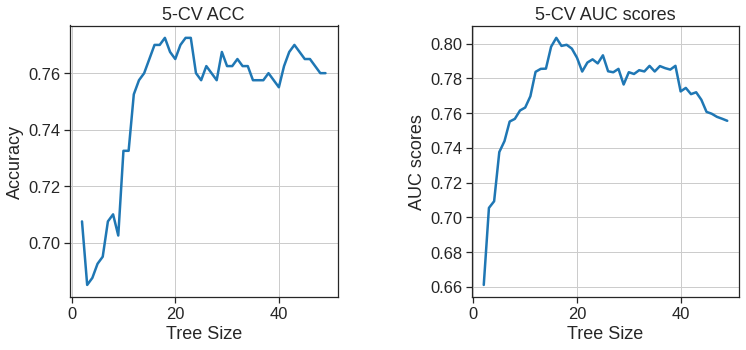

In [ ]:
tree_sizes = range(2, 50)

k = 5
kf5 = KFold(n_splits=k, shuffle=True, random_state=1)

ACC_scores = []
AUC_scores = []

# 10-Fold CV for each tree size 
for size in tree_sizes:
    clf_tree = DecisionTreeClassifier(max_leaf_nodes=size, random_state=1, criterion='entropy')
    ACC_s = cross_val_score(clf_tree, X, y, cv=kf5, scoring='accuracy')
    AUC_s = cross_val_score(clf_tree, X, y, cv=kf5, scoring='roc_auc')
    ACC_scores.append(np.mean(ACC_s))
    AUC_scores.append(np.mean(AUC_s))
    
# plot CV-Accuracy and AUC socres w.r.t tree sizes 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))          
fig.subplots_adjust(wspace=0.5)

ax1.plot(tree_sizes, ACC_scores)
ax1.set_title('5-CV ACC')
ax1.set_xlabel('Tree Size')
ax1.set_ylabel('Accuracy')
ax1.grid(True)

ax2.plot(tree_sizes, AUC_scores)
ax2.set_title('5-CV AUC scores')
ax2.set_xlabel('Tree Size')
ax2.set_ylabel('AUC scores')
ax2.grid(True)

In [ ]:
np.array(ACC_scores).argmax()

16

How well does this pruned tree perform on the test data set? Once again, we apply the `predict()` function.

In [ ]:
clf_tree = DecisionTreeClassifier(max_leaf_nodes=18, random_state=1, criterion='entropy')
clf_tree.fit(X_train, y_train)

y_pred = clf_tree.predict(X_test)
y_pred_prob = clf_tree.predict_proba(X_test)

conf_mat = confusion_matrix(y_test, y_pred)     
print(conf_mat)
TP = conf_mat[1,1]
TN = conf_mat[0,0]
FP = conf_mat[0,1]
FN = conf_mat[1,0]

print("Accuracy: ", (TP+TN) / (TP+TN+FP+FN) )
print("Sensitivity: ",  TP / (FN + TP) )
print("Precision: ",  TP / (FP + TP) )
print("False Positive Rate: ",  FP / (FP + TN) )
print("AUC Score: ", roc_auc_score(y_test, y_pred_prob[:,1]) )

[[100  19]
 [ 32  49]]
Accuracy:  0.745
Sensitivity:  0.6049382716049383
Precision:  0.7205882352941176
False Positive Rate:  0.15966386554621848
AUC Score:  0.772849880693018


Now $74.5\,\%$ of the test observations are correctly classified, so not only has the pruning process produced a more interpretable tree, but it has also slightly improved the classification accuracy.

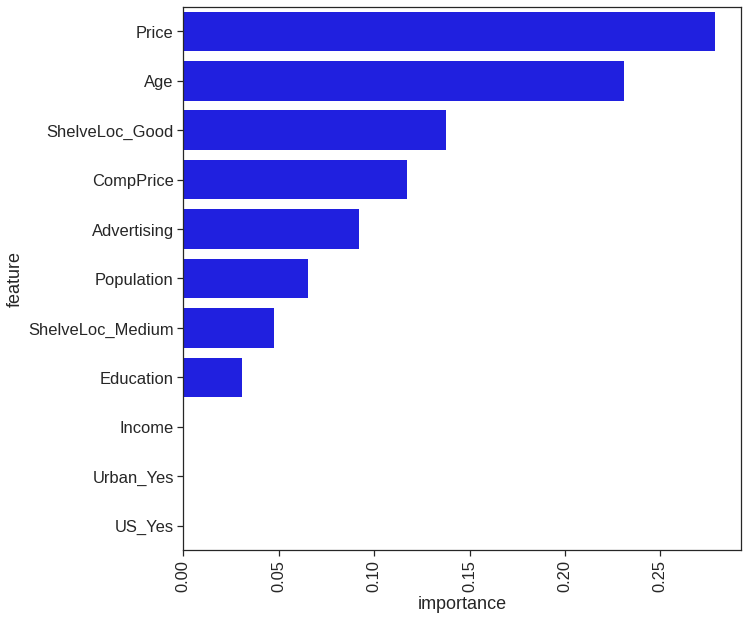

In [ ]:
# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': X.columns, 'importance': clf_tree.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

cost complexity pruning can also be used in order to select a sequence of trees for consideration.

In [ ]:
clf_tree = DecisionTreeClassifier(random_state=1, criterion='entropy')
path = clf_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

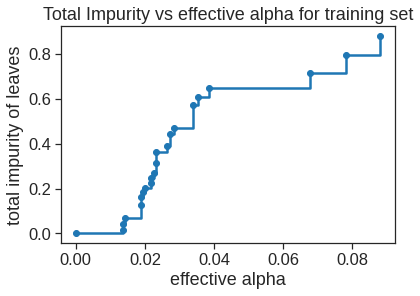

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, criterion='entropy', ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0974240009819235


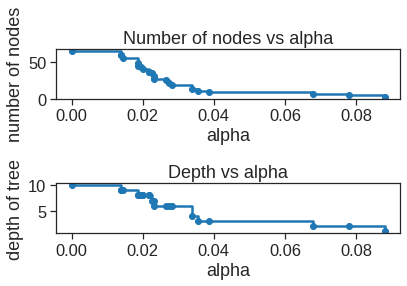

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Check [https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html) and [https://scikit-learn.org/stable/modules/tree.html](https://scikit-learn.org/stable/modules/tree.html) for more details

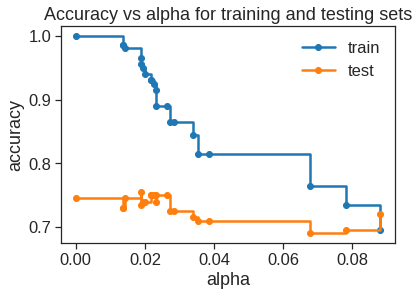

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Other metrics `min_samples_leaf` and `max_depth` can also be used  to prevent a tree from overfiting

## Fitting Regression Trees

Here we fit a regression tree to the `Boston`  data set. First, we create a training set, and fit the tree to the training data.

In [121]:
# Load 'Boston' data
Boston = pd.read_csv('/content/drive/MyDrive/Lab/Data/Boston.csv')
Boston = Boston.drop('Unnamed: 0', axis=1)
Boston.info()    # all numeric.  no Null,  Nice 
Boston.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [122]:
X = Boston.drop('medv', axis=1)
y = Boston.medv
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1)

In [123]:
reg_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5, random_state=1)
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=5, random_state=1)

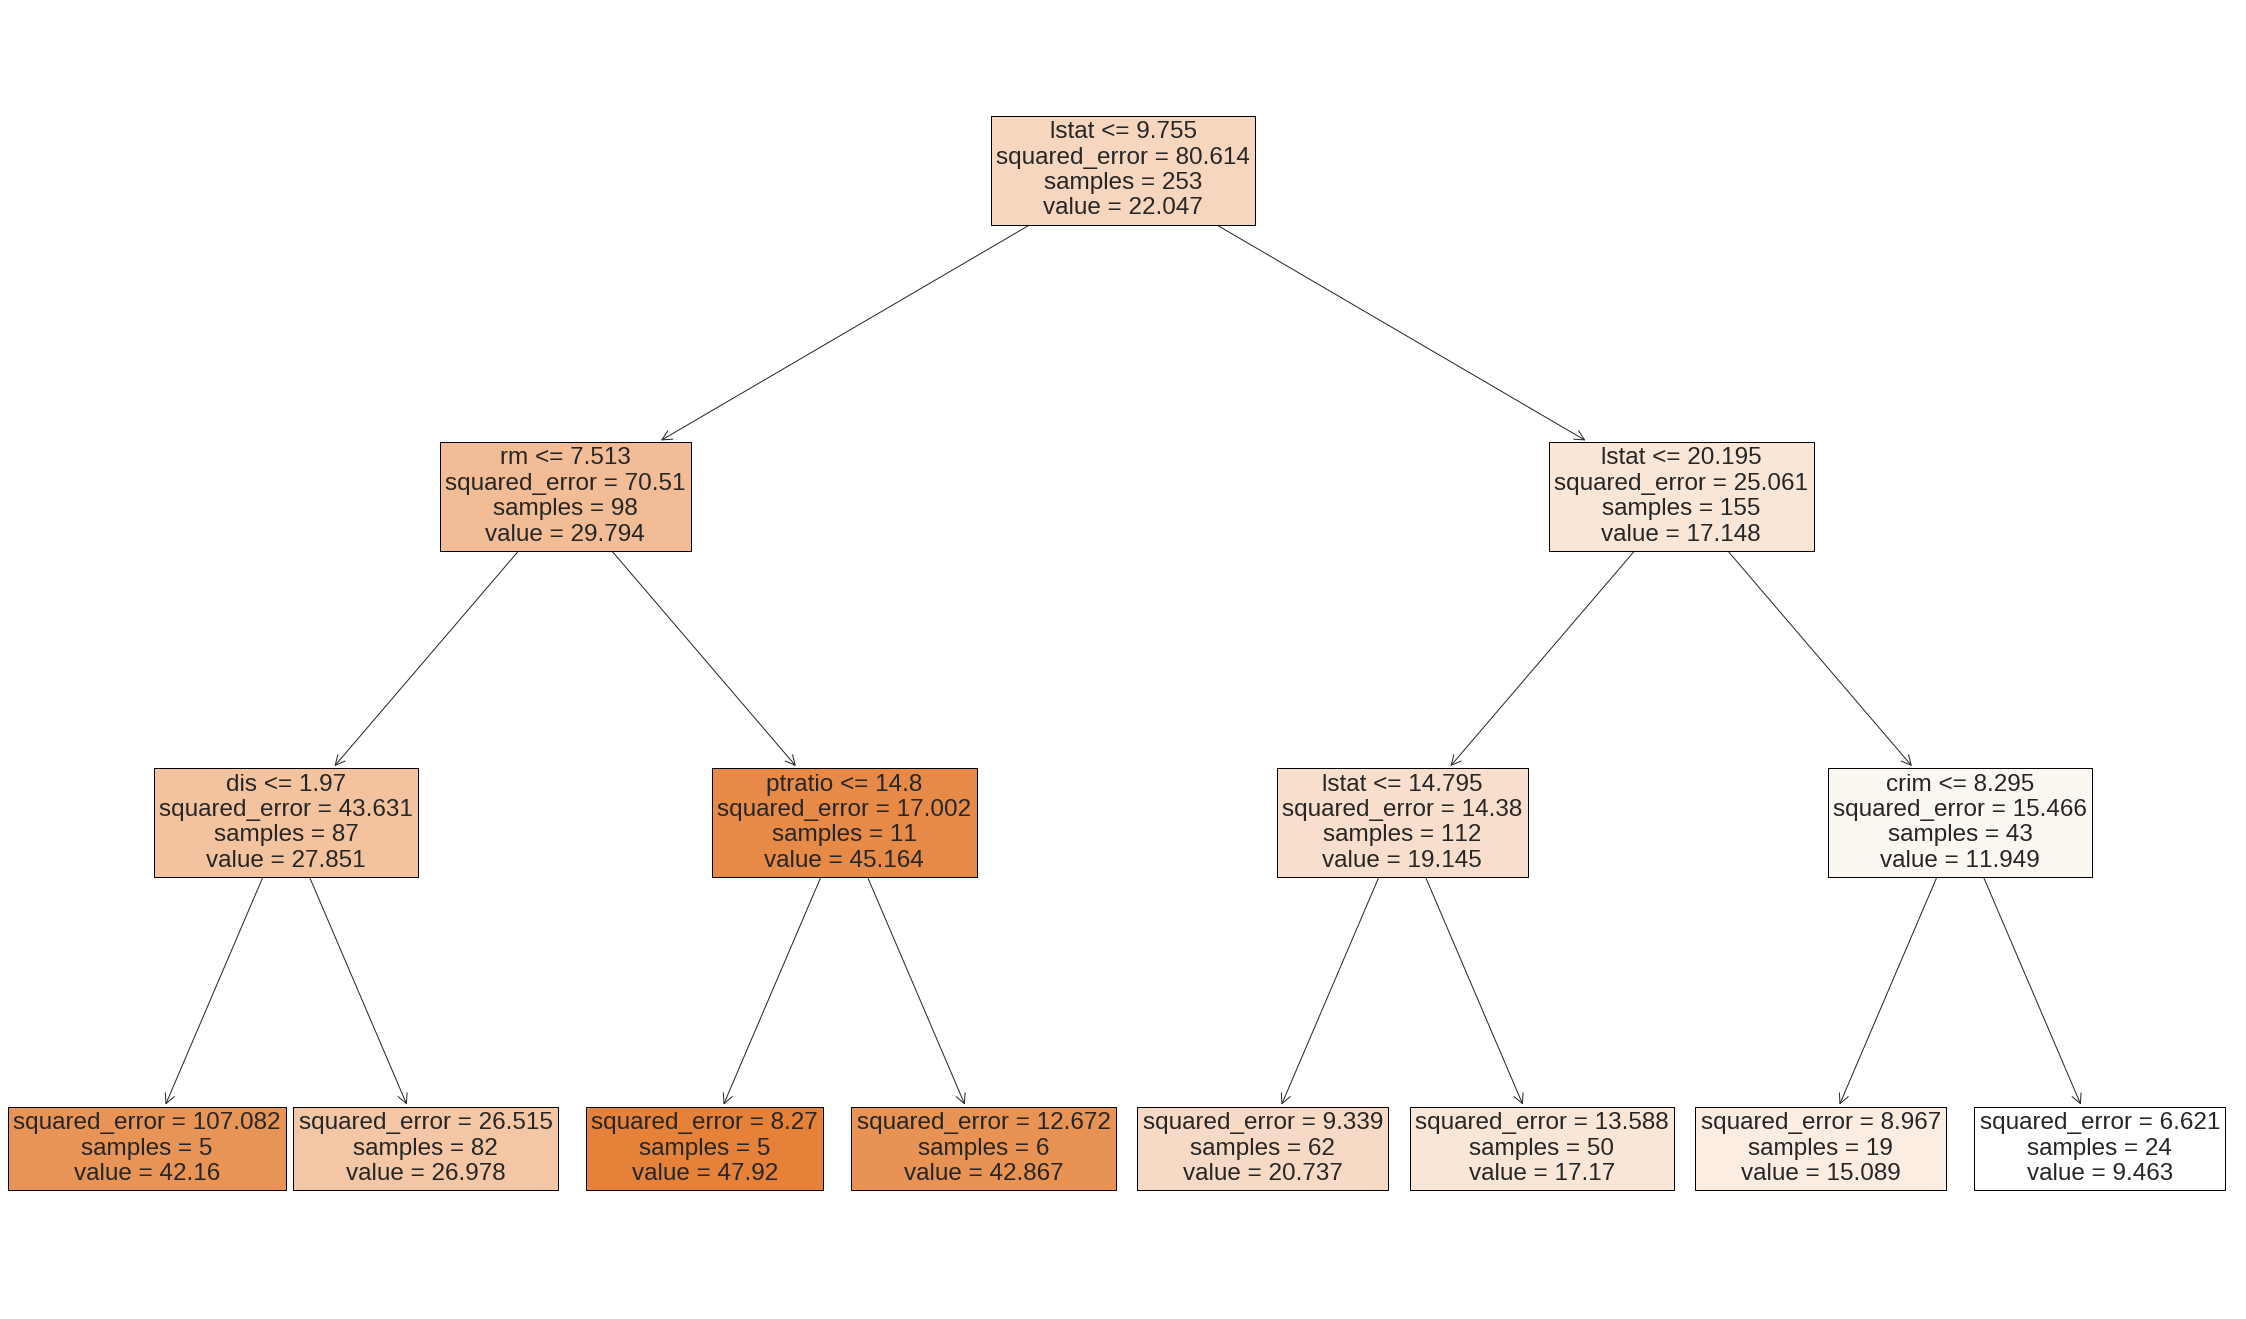

In [124]:
plt.figure(figsize=(40,24))
tree.plot_tree(reg_tree, feature_names=X.columns,  
                    class_names=['No','Yes'],
                    filled=True)
plt.show()

The variable `lstat` measures the percentage of individuals with {lower  socioeconomic status}, while the variable `rm` corresponds to the average number of rooms. The tree indicates that larger values of `rm`, or lower values of `lstat`, correspond to more expensive houses.

Now we use the cross validation to see whether pruning the tree will improve performance.

best tree size =  7


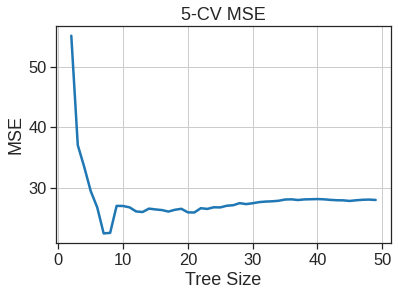

In [125]:
tree_sizes = range(2, 50)

k = 5
kf5 = KFold(n_splits=k, shuffle=True, random_state=1)

MSE_scores = []

# 7-Fold CV for each tree size 
for size in tree_sizes:
    reg_tree = DecisionTreeRegressor(max_leaf_nodes=size, random_state=1)
    MSE_s = -cross_val_score(reg_tree, X, y, cv=kf5, scoring='neg_mean_squared_error')
    MSE_scores.append(np.mean(MSE_s))
    
# plot CV-MSE as tree size gets bigger 
plt.plot(tree_sizes, MSE_scores)
plt.title('5-CV MSE')
plt.xlabel('Tree Size')
plt.ylabel('MSE')
plt.grid(True)

print("best tree size = ", tree_sizes[np.argmin(MSE_scores)]) #np.argmin(MSE_scores)=5

In [126]:
reg_tree = DecisionTreeRegressor(max_leaf_nodes=7, random_state=1)
reg_tree.fit(X_train, y_train)
pred = reg_tree.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

17.924645209941158 4.2337507260042075


Text(0, 0.5, 'y_test')

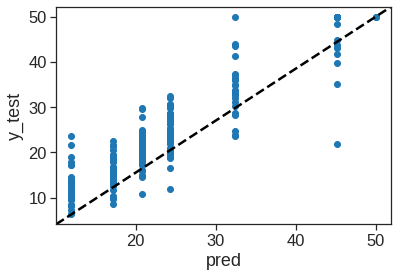

In [127]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In other words, the  test set MSE associated with the regression tree is $17.92$.
The square root of the MSE is therefore around $4.234$, indicating that this model leads to test predictions that are (on average) within approximately $4,234$ of the true median home value for the census tract.


## Bagging and Random Forests

Here we apply bagging and random forests to the `Boston` data. Recall that **bagging** is simply a special case of
a **random forest** with $m = p$. Therefore, the `RandomForestRegressor()` function can
be used to perform both random forests and bagging. Let's start with bagging:

In [128]:
# Bagging: using all features
max_features = X.shape[1]
tree_count   = 100
regr1 = RandomForestRegressor(max_features=max_features, random_state=2, n_estimators=tree_count)
regr1.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=2)

The argument `max_features=12` indicates that all 12 predictors should be considered for each split of the tree -- in other words, that bagging should be done. How
well does this bagged model perform on the test set?

11.56611499209486 3.4008991446520227


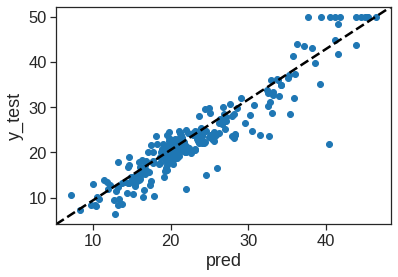

In [129]:
pred = regr1.predict(X_test)
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

We can grow a random forest in exactly the same way, except that we'll use a smaller value of the `max_features` argument. Here we'll
use `max_features = 6`:

In [130]:
# Random forests: using 6 features
tree_count   = 100
regr2 = RandomForestRegressor(max_features=6, random_state=2, n_estimators=tree_count)
regr2.fit(X_train, y_train)

pred = regr2.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

11.210173703557313 3.3481597488108767


The test set MSE is even lower; this indicates that random forests yielded an
improvement over bagging in this case.

Using the `feature_importances` attribute of the `RandomForestRegressor`, we can view the importance of each
variable:

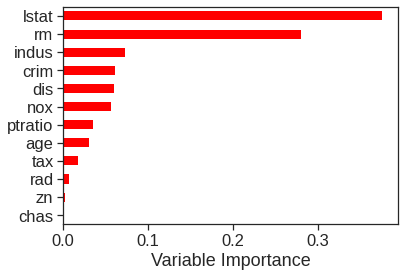

In [131]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_}, index=X.columns)
Importance.sort_values(by='Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

The results indicate that across all of the trees considered in the random forest, the wealth of the community (`lstat`) and the house size (`rm`) are by far the two most important variables.



## Boosting

Here we use the `GradientBoostingRegressor()` function, to fit boosted regression trees to the `Boston` data set. 

In [132]:
# Gradient boosting

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 'max_features': 'sqrt', 'subsample' : 0.9,
          'learning_rate': 0.01, 'loss': 'squared_error', 'random_state': 1}

regr3   = GradientBoostingRegressor(**params)
regr3.fit(X_train, y_train)

pred = regr3.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

10.585712502747185 3.2535691943997724


In [133]:
# Gradient boosting

params = {'n_estimators': 100, 'max_features': 'sqrt', 
          'learning_rate': 0.1, 'random_state': 10}

regr3   = GradientBoostingRegressor(**params)
regr3.fit(X_train, y_train)

pred = regr3.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

10.377996557875113 3.2214898040929936


The test MSE obtained is $10.38$: this is superior to the test MSE of random forests and bagging.

Train/Test Split GBR with 500 estimators: 10.3780


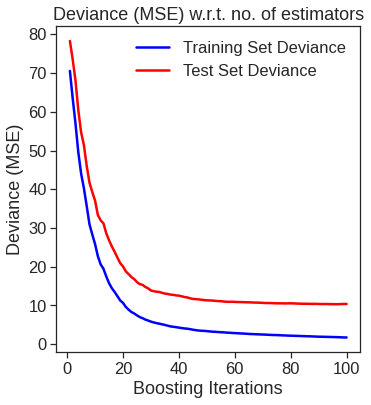

In [134]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

# compute test set deviance
for i, y_pred in enumerate(regr3.staged_predict(X_test)):   
    test_score[i] = regr3.loss_(y_test, y_pred)             

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance (MSE) w.r.t. no. of estimators')
plt.plot(np.arange(params['n_estimators']) + 1, regr3.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance (MSE)')
print("Train/Test Split GBR with 500 estimators: %.4f" % test_score[-1])

chas       0.001323
rad        0.002557
zn         0.020765
age        0.023923
tax        0.051350
crim       0.061762
ptratio    0.075320
dis        0.096075
indus      0.098711
nox        0.105943
lstat      0.219331
rm         0.242939
dtype: float64


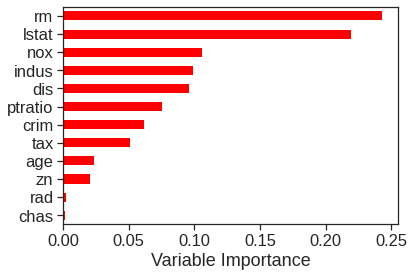

In [135]:
feature_importance = regr3.feature_importances_
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

We see that `lstat` and `rm` are by far the most important variables. We can also produce *partial dependence plots* for these two variables. These plots illustrate the marginal effect of the selected variables on the response after *integrating* out the other variables. In this case, as we might expect, median house prices are increasing with `rm` and decreasing with `lstat`.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


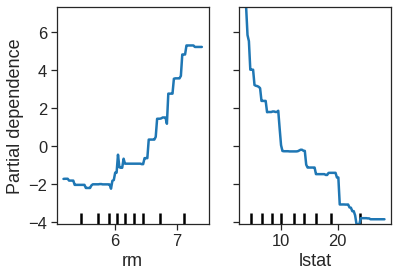

In [136]:
# Partial Dependence Plots
disp1 = plot_partial_dependence(regr3,  X_train, [5, 11], feature_names=X.columns)  

### AdaBoost

In [137]:
ada_regr = AdaBoostRegressor(n_estimators=100, random_state=1)

ada_regr.fit(X_train, y_train)

pred = ada_regr.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

15.134274042481255 3.8902794298714913


Check https://scikit-learn.org/stable/modules/ensemble.html#adaboost for more detail

## Bayesian Additive Regression Trees

In this section  we use the `bartpy` package, and within it the `SklearnModel()` function, to fit a Bayesian additive regression tree model to the `Boston` housing data set. **On colab the following code may takes 5~10 minutes to run with default value**.


In [138]:
model = SklearnModel() # Use default parameters
model.fit(X_train, y_train) # Fit the model

pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(mse, rmse)

13.771499662519378 3.710997125102548


Chcek [https://jakecoltman.github.io/bartpy/](https://jakecoltman.github.io/bartpy/) for more details

## XGBoost

### Classification task

Here are the essential steps to build an XGBoost classification model in scikit-learn using cross-validation.

In [ ]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=42)

The following template is for building an XGBoost classifier

In [ ]:
xgb = XGBClassifier(booster='gbtree', objective='multi:softprob', 
                    learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)

1. `booster='gbtree'`: The booster is the base learner. It's the machine learning model that is constructed during every round of boosting. You may have guessed that 'gbtree' stands for gradient boosted tree, the XGBoost default base learner. It's uncommon but possible to work with other base learners, 

2. `objective='multi:softprob'`: Standard options for the objective can be viewed in the XGBoost official documentation, [https://xgboost.readthedocs.io/en/latest/parameter.html](https://xgboost.readthedocs.io/en/latest/parameter.html), under Learning Task Parameters. The multi:softprob objective is a standard alternative to binary:logistic when the dataset includes multiple classes. It computes the probabilities of classification and chooses the highest one. If not explicitly stated, XGBoost will often find the right objective for you.

3. `max_depth=6`: The max_depth of a tree determines the number of branches each tree has. It's one of the most important hyperparameters in making balanced predictions. XGBoost uses a default of 6, unlike random forests, which don't provide a value unless explicitly programmed.

3. `learning_rate=0.1`: Within XGBoost, this hyperparameter is often referred to as eta. This hyperparameter limits the variance by reducing the weight of each tree to the given percentage. 

4. `n_estimators=100`: Popular among ensemble methods, `n_estimators` is the number of boosted trees in the model. Increasing this number while decreasing `learning_rate` can lead to more robust results.

In [ ]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 1.0


In [ ]:
xgb.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

### Regression task

Here are the essential steps to build an XGBoost regression model in scikit-learn using cross-validation.

In [ ]:
X,y = datasets.load_diabetes(return_X_y=True)

xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror', 
                    learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)

scores = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=5)

# Take square root of the scores
rmse = np.sqrt(-scores)

# Display accuracy
print('RMSE:', np.round(rmse, 3))

# Display mean score
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [63.033 59.689 64.538 63.699 64.661]
RMSE mean: 63.124


In [ ]:
xgb.fit(X,y)
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

Without a baseline of comparison, we have no idea what that score means. Converting the target column, `y`, into a pandas DataFrame with the `.describe()` method will give the quartiles and the general statistics of the predictor column, as follows:

In [ ]:
pd.DataFrame(y).describe()

,0
count,442.000000
mean,152.133484
std,77.093005
min,25.000000
25%,87.000000
50%,140.500000
75%,211.500000
max,346.000000


A score of 63.124 is less than 1 standard deviation, a respectable result.

### Speed comparsion

Let's now compare `GradientBoostingClassifier` and `XGBoostClassifier` with the [exoplanet dataset](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data) for its speed 

In [ ]:
!wget https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter04/exoplanets.csv

--2022-11-08 09:14:53--  https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter04/exoplanets.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter04/exoplanets.csv [following]
--2022-11-08 09:14:53--  https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter04/exoplanets.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262223348 (250M) [text/plain]
Saving to: ‘exopla

In [ ]:
df = pd.read_csv('exoplanets.csv')
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [ ]:
# Split data into X and y
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
start = time.time()

gbr = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9874213836477987
Run Time: 318.0388216972351 seconds


In [ ]:
start = time.time()

# Instantiate the XGBRegressor, xg_reg
xg_reg = XGBClassifier(n_estimators=100, max_depth=2, random_state=42)

# class column has to start from 0 (as required since version 1.3.2).
le = LabelEncoder() # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
# Fit xg_reg to training set
xg_reg.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = xg_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9913522012578616
Run Time: 71.92710447311401 seconds


When it comes to big data, an algorithm five as fast can save weeks or months of computational time and resources! This advantage is huge in the world of big data. In the world of boosting, XGBoost is the model of choice due to its unparalleled speed and impressive accuracy.

### Hyperparameter

XGBoost has many hyperparameters. XGBoost base learner hyperparameters incorporate all decision tree hyperparameters as a starting point. There are gradient boosting hyperparameters, since XGBoost is an enhanced version of gradient boosting.

In [ ]:
!wget https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter06/heart_disease.csv

--2022-11-08 09:22:39--  https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter06/heart_disease.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter06/heart_disease.csv [following]
--2022-11-08 09:22:39--  https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter06/heart_disease.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11328 (11K) [text/plain]
Saving to: ‘he

In [ ]:
df = pd.read_csv('heart_disease.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
# Split data into X and y
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

Before tuning hyperparameters, let's build a classifier so that we can obtain a baseline score as a starting point.

When fine-tuning hyperparameters, GridSearchCV and RandomizedSearchCV are the standard options. However, `cross_val_score` and `GridSearchCV/RandomizedSearchCV` do not split data the same way. One solution is to use `StratifiedKFold` whenever cross-validation is used.

A stratified fold includes the same percentage of target values in each fold. If a dataset contains 60% 1s and 40% 0s in the target column, each stratified test set contains 60% 1s and 40% 0s. When folds are random, it's possible that one test set contains a 70-30 split while another contains a 50-50 split of target values.

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# The 'binary:logistic' objective is standard for binary classification in determining the loss function
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
# Obtain scores of cross-validation
scores = cross_val_score(model, X, y, cv=kfold)

# Display accuracy
print('Accuracy:', np.round(scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores.mean()))

Accuracy: [0.85 0.72 0.74 0.82 0.78]
Accuracy mean: 0.78


The point here is to use the same folds to obtain new scores when fine-tuning hyperparameters with GridSearchCV and RandomizedSearchCV so that the comparison of scores is fair.

In [ ]:
def grid_search(params, random=False): 
    
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, n_jobs=-1, random_state=42)
    else:
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)
    
    # Fit grid_reg on X_train and y_train
    grid.fit(X, y)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

The XGBoost hyperparameters presented here are not meant to be exhaustive, but they are meant to be comprehensive. For a complete list of hyperparameters, read the official documentation, XGBoost Parameters, at [https://xgboost.readthedocs.io/en/latest/parameter.html](https://xgboost.readthedocs.io/en/latest/parameter.html).

#### learning_rate

`learning_rate` shrinks the weights of trees for each round of boosting. By lowering `learning_rate`, more trees are required to produce better scores. Lowering `learning_rate` prevents overfitting because the size of the weights carried forward is smaller.

A default value of 0.3 is used. Here is a starting range for `learning_rate` as placed inside our grid_search function:

In [ ]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]})

Best params: {'learning_rate': 0.5}
Best score: 0.80525


lowering `learning_rate` may be advantageous when `n_estimators` goes up.

#### max_depth

`max_depth` determines the length of the tree, equivalent to the number of rounds of splitting. Limiting `max_depth` prevents overfitting because the individual trees can only grow as far as `max_depth` allows. XGBoost provides a default `max_depth` value of six:

In [ ]:
grid_search(params={'max_depth':[2, 3, 5, 6, 8]})

Best params: {'max_depth': 2}
Best score: 0.79552


Changing `max_depth` from 6 to 2 gave a better score. The lower value for `max_depth` means variance has been reduced.

#### gamma

Known as a Lagrange multiplier, `gamma` provides a threshold that nodes must surpass before making further splits according to the loss function. There is no upper limit to the value of `gamma`. The default is 0, and anything over 10 is considered very high. Increasing `gamma` results in a more conservative model:

In [ ]:
grid_search(params={'gamma':[0, 0.01, 0.1, 0.5, 1, 2]})

Best params: {'gamma': 1}
Best score: 0.79880


Changing gamma from 0 to 1 has resulted in a slight improvement.

#### min_child_weight

`min_child_weight` refers to the minimum sum of weights required for a node to split into a child. If the sum of the weights is less than the value of `min_child_weight`, no further splits are made. `min_child_weight` reduces overfitting by increasing its value:

In [ ]:
grid_search(params={'min_child_weight':[1, 2, 3, 4, 5]})

Best params: {'min_child_weight': 5}
Best score: 0.81202


A slight adjustment to `min_child_weight` form 1 to 5 gives the best results yet.

#### subsample

The `subsample` hyperparameter limits the percentage of training instances (rows) for each boosting round. Decreasing `subsample` from 100% reduces overfitting:

In [ ]:
grid_search(params={'subsample':[0.5, 0.7, 0.8, 0.9, 1]})

Best params: {'subsample': 0.5}
Best score: 0.82525


The score has improved by a slight amount once again, indicating a small presence of overfitting.

#### colsample_bytree

Similar to `subsample`, `colsample_bytree` randomly selects particular columns according to the given percentage. `colsample_bytree` is useful for limiting the influence of columns and reducing variance. Note that `colsample_bytree` takes a percentage as input, not the number of columns:

In [ ]:
grid_search(params={'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1]})

Best params: {'colsample_bytree': 0.5}
Best score: 0.79874


You are encouraged to try `colsample_bylevel` and `colsample_bynode` on your own. `colsample_bylevel` randomly selects columns for each tree depth, and `colsample_bynode` randomly selects columns when evaluating each tree split.

#### n_estimators

Recall that `n_estimators` provides the number of trees in the ensemble. In the case of XGBoost, `n_estimators` is the number of trees trained on the residuals. Initialize a grid search of `n_estimators` with the default of 100, then double the number of trees through 800 as follows:

In [ ]:
grid_search(params={'n_estimators':[100, 200, 400, 800]})

Best params: {'n_estimators': 200}
Best score: 0.79219


Since our dataset is small, increasing `n_estimators` did not produce better results.

#### Applying early stopping

`early_stopping_rounds` is not a hyperparameter, but a strategy for optimizing the `n_estimators` hyperparameter.

Normally when choosing hyperparameters, a test score is given after all boosting rounds are complete. To use early stopping, we need a test score after each round. `eval_metric` and `eval_set` may be used as parameters for `.fit` to generate test scores for each training round. `eval_metric` provides the scoring method, commonly 'error' for classification, and 'rmse' for regression. `eval_set` provides the test to be evaluated, commonly X_test and y_test.

The following steps display an evaluation metric for each round of training with the default `n_estimators=100:`

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
eval_set = [(X_test, y_test)]
eval_metric='error'
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set)
# make predictions for test data
y_pred = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.23684
[1]	validation_0-error:0.22368
[2]	validation_0-error:0.22368
[3]	validation_0-error:0.21053
[4]	validation_0-error:0.22368
[5]	validation_0-error:0.18421
[6]	validation_0-error:0.21053
[7]	validation_0-error:0.22368
[8]	validation_0-error:0.19737
[9]	validation_0-error:0.19737
[10]	validation_0-error:0.18421
[11]	validation_0-error:0.18421
[12]	validation_0-error:0.19737


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[13]	validation_0-error:0.17105
[14]	validation_0-error:0.18421
[15]	validation_0-error:0.18421
[16]	validation_0-error:0.18421
[17]	validation_0-error:0.18421
[18]	validation_0-error:0.18421
[19]	validation_0-error:0.19737
[20]	validation_0-error:0.18421
[21]	validation_0-error:0.18421
[22]	validation_0-error:0.18421
[23]	validation_0-error:0.18421
[24]	validation_0-error:0.18421
[25]	validation_0-error:0.18421
[26]	validation_0-error:0.18421
[27]	validation_0-error:0.18421
[28]	validation_0-error:0.18421
[29]	validation_0-error:0.18421
[30]	validation_0-error:0.18421
[31]	validation_0-error:0.17105
[32]	validation_0-error:0.18421
[33]	validation_0-error:0.18421
[34]	validation_0-error:0.18421
[35]	validation_0-error:0.17105
[36]	validation_0-error:0.17105
[37]	validation_0-error:0.17105
[38]	validation_0-error:0.18421
[39]	validation_0-error:0.17105
[40]	validation_0-error:0.18421
[41]	validation_0-error:0.18421
[42]	validation_0-error:0.18421
[43]	validation_0-error:0.18421
[44]	val

We know that `StratifiedKFold` cross-validation gives a mean accuracy of 78% when n_estimators=100. The disparity in scores comes from the difference in test sets.

#### early_stopping_rounds

`early_stopping_rounds` is an optional parameter to include with `eval_metric` and `eval_set` when fitting a model. Let's try `early_stopping_rounds=10`.
The previous code is repeated with `early_stopping_rounds=10` added in:

In [ ]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
eval_set = [(X_test, y_test)]
eval_metric="error"
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, early_stopping_rounds=10, verbose=True)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.23684
[1]	validation_0-error:0.22368
[2]	validation_0-error:0.22368
[3]	validation_0-error:0.21053
[4]	validation_0-error:0.22368
[5]	validation_0-error:0.18421
[6]	validation_0-error:0.21053
[7]	validation_0-error:0.22368
[8]	validation_0-error:0.19737


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[9]	validation_0-error:0.19737
[10]	validation_0-error:0.18421
[11]	validation_0-error:0.18421
[12]	validation_0-error:0.19737
[13]	validation_0-error:0.17105
[14]	validation_0-error:0.18421
[15]	validation_0-error:0.18421
[16]	validation_0-error:0.18421
[17]	validation_0-error:0.18421
[18]	validation_0-error:0.18421
[19]	validation_0-error:0.19737
[20]	validation_0-error:0.18421
[21]	validation_0-error:0.18421
[22]	validation_0-error:0.18421
[23]	validation_0-error:0.18421
Accuracy: 82.89%


A more thorough approach is to use larger values, say, `n_estimators = 5000` and `early_stopping_rounds=100`. By setting `early_stopping_rounds=100`, you are guaranteed to reach the default of 100 boosted trees presented by XGBoost.
Here is the code that gives a maximum of 5,000 trees and that will stop after 100 consecutive rounds fail to find any improvement:

In [ ]:
model = XGBClassifier(random_state=42, n_estimators=5000)
eval_set = [(X_test, y_test)]
eval_metric="error"
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, early_stopping_rounds=100)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.23684
[1]	validation_0-error:0.22368
[2]	validation_0-error:0.22368
[3]	validation_0-error:0.21053
[4]	validation_0-error:0.22368
[5]	validation_0-error:0.18421
[6]	validation_0-error:0.21053
[7]	validation_0-error:0.22368
[8]	validation_0-error:0.19737
[9]	validation_0-error:0.19737
[10]	validation_0-error:0.18421
[11]	validation_0-error:0.18421


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[12]	validation_0-error:0.19737
[13]	validation_0-error:0.17105
[14]	validation_0-error:0.18421
[15]	validation_0-error:0.18421
[16]	validation_0-error:0.18421
[17]	validation_0-error:0.18421
[18]	validation_0-error:0.18421
[19]	validation_0-error:0.19737
[20]	validation_0-error:0.18421
[21]	validation_0-error:0.18421
[22]	validation_0-error:0.18421
[23]	validation_0-error:0.18421
[24]	validation_0-error:0.18421
[25]	validation_0-error:0.18421
[26]	validation_0-error:0.18421
[27]	validation_0-error:0.18421
[28]	validation_0-error:0.18421
[29]	validation_0-error:0.18421
[30]	validation_0-error:0.18421
[31]	validation_0-error:0.17105
[32]	validation_0-error:0.18421
[33]	validation_0-error:0.18421
[34]	validation_0-error:0.18421
[35]	validation_0-error:0.17105
[36]	validation_0-error:0.17105
[37]	validation_0-error:0.17105
[38]	validation_0-error:0.18421
[39]	validation_0-error:0.17105
[40]	validation_0-error:0.18421
[41]	validation_0-error:0.18421
[42]	validation_0-error:0.18421
[43]	val

After 100 rounds of boosting, the score provided by 13 trees is the best.

#### Automatically hyperparamter tuning

You are encourage to try [https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py](https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py) for hyperparameter tuning.

### For categorical variable and missing value

XGBoost has experiment support for categorical variable, you can check out here: [https://xgboost.readthedocs.io/en/latest/tutorials/categorical.html](https://xgboost.readthedocs.io/en/latest/tutorials/categorical.html). But it only works for a few tree methods, it is still recommend to encode your data [https://www.kaggle.com/code/shahules/an-overview-of-encoding-techniques/notebook](https://www.kaggle.com/code/shahules/an-overview-of-encoding-techniques/notebook). Missing value, on the other hand can be handled by XGBoost as described at [https://xgboost.readthedocs.io/en/stable/faq.html#how-to-deal-with-missing-values](https://xgboost.readthedocs.io/en/stable/faq.html#how-to-deal-with-missing-values).

In [75]:
!gdown 1WkuxuToarMFAHYIQ85SW20YSXrfJsMEH

Downloading...
From: https://drive.google.com/uc?id=1WkuxuToarMFAHYIQ85SW20YSXrfJsMEH
To: /content/melb_data.csv
100% 2.09M/2.09M [00:00<00:00, 36.3MB/s]


In [76]:
# Select target
data = pd.read_csv('melb_data.csv')
y = data.Price

# To keep things simple, we'll split the columns into numerical can categorical features
melb_predictors = data.drop(['Price', 'Date', 'Address'], axis=1)
cat_col = melb_predictors.select_dtypes(exclude=['int64','float64'])

# Divide data into training and validation subsets
X, X_v, y_train, y_valid = train_test_split(melb_predictors, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X.select_dtypes(exclude=['object'])
X_valid = X_v.select_dtypes(exclude=['object'])
X_train_cat = X.select_dtypes(exclude=['int64','float64'])
X_valid_cat = X_v.select_dtypes(exclude=['int64','float64'])

In [77]:
for col in X_train_cat.columns:
  X[col] = X[col].astype('category')
  X_v[col] = X_v[col].astype('category')

In [78]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror', 
                    random_state=42, n_jobs=-1) # You can either specify missing=-9999 or leave it as it is
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [79]:
preds = xgb.predict(X_valid)

In [80]:
mean_absolute_error(y_valid, preds)

173639.76325478646

## Lightgbm

### Classification task

In [81]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=42)

In [82]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

LGBMClassifier(random_state=42)

In [83]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 1.0


In [84]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Regression task

In [85]:
X,y = datasets.load_diabetes(return_X_y=True)

lgbr = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)

scores = cross_val_score(lgbr, X, y, scoring='neg_mean_squared_error', cv=5)

# Take square root of the scores
rmse = np.sqrt(-scores)

# Display accuracy
print('RMSE:', np.round(rmse, 3))

# Display mean score
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [56.081 59.172 63.191 61.833 60.542]
RMSE mean: 60.164


In [86]:
lgbr.fit(X,y)
lgbr.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Speed

In [87]:
df = pd.read_csv('exoplanets.csv')
# Split data into X and y
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [88]:
start = time.time()

# Instantiate the XGBRegressor, xg_reg
lg_reg = lgb.LGBMClassifier(n_estimators=100, max_depth=2, random_state=42)

# Fit xg_reg to training set
lg_reg.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = lg_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9913522012578616
Run Time: 10.266663074493408 seconds


### Hyperparameter

Following set of practices can be used to improve your model efficiency.

* **num_leaves** : This is the main parameter to control the complexity of the tree model. Ideally, the value of `num_leaves` should be less than or equal to 2^(max_depth). Value more than this will result in overfitting.

* **min_data_in_leaf** : Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.

* **max_depth** : We also can use `max_depth` to limit the tree depth explicitly.

1. **For Faster Speed**

* Use bagging by setting `bagging_fraction` and `bagging_freq`.
* Use feature sub-sampling by setting `feature_fraction`.
* Use small `max_bin`.
* Use `save_binary` to speed up data loading in future learning.

2. **For better accuracy**

* Use large `max_bin` (may be slower).
* Use small `learning_rate` with `large num_iterations`
* Use large `num_leaves`(may cause over-fitting)
* Try to use categorical feature directly.

3. **To deal with over-fitting**

* Use `min_data_in_leaf` and `min_sum_hessian_in_leaf`
* Try `lambda_l1`, `lambda_l2` and `min_gain_to_split` to regularization
* Try `max_depth` to avoid growing deep tree
* Try `dart`

Check [https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) for hyperparamter tuning.

### For categorical variable and missing value

LightGBM enables the missing value handle by default. See [https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#missing-value-handle](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#missing-value-handle). It also deal with categorical variables as described here [https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#categorical-feature-support](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#categorical-feature-support)

In [89]:
# Select target
data = pd.read_csv('melb_data.csv')
y = data.Price

# To keep things simple, we'll split the columns into numerical can categorical features
melb_predictors = data.drop(['Price', 'Date', 'Address'], axis=1)
cat_col = melb_predictors.select_dtypes(exclude=['int64','float64'])

# Divide data into training and validation subsets
X, X_v, y_train, y_valid = train_test_split(melb_predictors, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X.select_dtypes(exclude=['object'])
X_valid = X_v.select_dtypes(exclude=['object'])
X_train_cat = X.select_dtypes(exclude=['int64','float64'])
X_valid_cat = X_v.select_dtypes(exclude=['int64','float64'])

In [90]:
for col in X_train_cat.columns:
  X[col] = X[col].astype('category')
  X_v[col] = X_v[col].astype('category')

In [91]:
lgbr = lgb.LGBMRegressor(boosting_type='gbdt', random_state=42, n_jobs=-1)
lgbr.fit(X, y_train)

LGBMRegressor(random_state=42)

In [92]:
preds = lgbr.predict(X_v)

In [93]:
mean_absolute_error(y_valid, preds)

160267.37406568974

## CatBoost

In this section, we would explore some base cases of using catboost, such as model training, cross-validation and predicting

### Classification task

In [94]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=42)

In [95]:
clf = CatBoostClassifier(boosting_type='Plain', learning_rate=0.1, n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent')
clf.fit(X_train, y_train)

In [96]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 1.0


In [97]:
clf.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MultiClass',
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'class_names': [0, 1, 2],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'MultiClass',
 'learning_rate': 0.10000

### Regression

In [98]:
X,y = datasets.load_diabetes(return_X_y=True)

catb = CatBoostRegressor(boosting_type='Plain', learning_rate=0.1, random_state=42, n_estimators=100, thread_count=-1, logging_level = 'Silent')

scores = cross_val_score(catb, X, y, scoring='neg_mean_squared_error', cv=5)

# Take square root of the scores
rmse = np.sqrt(-scores)

# Display accuracy
print('RMSE:', np.round(rmse, 3))

# Display mean score
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [54.744 56.125 59.595 56.908 56.583]
RMSE mean: 56.791


In [99]:
catb.fit(X,y)
catb.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.10000000149011612,
 'score_function': '

### Speed

In [100]:
df = pd.read_csv('exoplanets.csv')
# Split data into X and y
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [101]:
start = time.time()

# Instantiate the XGBRegressor, xg_reg
ca_reg = CatBoostClassifier(n_estimators=100, max_depth=2, random_state=42, logging_level = 'Silent')

# Fit xg_reg to training set
ca_reg.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = ca_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9913522012578616
Run Time: 16.69258213043213 seconds


### Hyperparameter

You can check more details at [https://catboost.ai/en/docs/references/training-parameters/](https://catboost.ai/en/docs/references/training-parameters/). There are also tutorials about hyperparameter tuning [https://github.com/catboost/tutorials/blob/master/hyperparameters_tuning/hyperparameters_tuning_using_optuna_and_hyperopt.ipynb](https://github.com/catboost/tutorials/blob/master/hyperparameters_tuning/hyperparameters_tuning_using_optuna_and_hyperopt.ipynb)

### For categorical variable and missing value

One of the differences between CatBoost and other gradient boosting libraries is its advanced processing of the categorical features (in fact "Cat" in the package name stands for "CATegorical").

CatBoost deals with the categorical data quite well out-of-the-box. However, it also has a huge number of training parameters, which provide fine control over the categorical features preprocessing.

The amount of parameters related to categorical features processing in CatBoost is overwhelming. Here is a hopefully the full list:

* `one_hot_max_size` (int) - use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. No complex encoding is performed for such features. 

* `model_size_reg` (float from 0 to inf) - The model size regularization coefficient. The larger the value, the smaller the model size. This regularization is needed only for models with categorical features (other models are small). Models with categorical features might weight tens of gigabytes or more if categorical features have a lot of values. If the value of the regularizer differs from zero, then the usage of categorical features or feature combinations with a lot of values has a penalty, so fewer of them are used in the resulting model. Default value is 0.5

* `max_ctr_complexity` - The maximum number of features that can be combined. Each resulting combination consists of one or more categorical features and can optionally contain binary features in the following form: “numeric feature > value”. For regression task on CPU the default value is 4.

* `has_time (bool)` - if true, the 1-st step of categorical features processing, permutation, is not performed. Useful when the objects in your dataset are ordered by time. For our dataset, we don't need it. Default value is False

* `simple_ctr` - Quantization settings for simple categorical features.
combinations_ctr - Quantization settings for combinations of categorical features.

* `per_feature_ctr` - Per-feature quantization settings for categorical features.

* `counter_calc_method` determines whether to use validation dataset (provided through parameter eval_set of fit method) to estimate categories frequencies with Counter. By default, it is Full and the objects from validation dataset are used; Pass SkipTest value to ignore the objects from the validation set
ctr_target_border_count - The maximum number of borders to use in target quantization for categorical features that need it. Default for regression task is 1.

* `ctr_leaf_count_limit` - The maximum number of leaves with categorical features. Default value is None i.e. no limit.

* `store_all_simple_ctr`- If the previous parameter ctr_leaf_count_limit at some point gradient boosting tree can no longer make splits by categorical features. With Default value False the limitation applies both to original categorical features and the features, that CatBoost creates by combining different features. If this parameter is set to True only the number of splits made on combination features is limited.

The three parameters `simple_ctr`, `combinations_ctr`, and `per_feature_ctr` are complex parameters that control the second and the third steps of categorical features processing.

In [102]:
# Select target
data = pd.read_csv('melb_data.csv')
y = data.Price

# To keep things simple, we'll split the columns into numerical can categorical features
melb_predictors = data.drop(['Price', 'Date', 'Address'], axis=1)
cat_col = melb_predictors.select_dtypes(exclude=['int64','float64'])

# Divide data into training and validation subsets
X, X_v, y_train, y_valid = train_test_split(melb_predictors, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X.select_dtypes(exclude=['object'])
X_valid = X_v.select_dtypes(exclude=['object'])
X_train_cat = X.select_dtypes(exclude=['int64','float64'])
X_valid_cat = X_v.select_dtypes(exclude=['int64','float64'])

In [103]:
categorical_features_names = list(X_train_cat.columns)

for col in categorical_features_names:
  X[col] = X.loc[:,col].fillna(value='nan')
  X_v[col] = X_v.loc[:,col].fillna(value='nan')
  X[col] = X[col].astype('category')
  X_v[col] = X_v[col].astype('category')

In [104]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names)
catbr.fit(X, y_train)

In [105]:
preds = catbr.predict(X_v)

In [106]:
mean_absolute_error(y_valid, preds)

164721.46472522244

The first thing we try is to make CatBoost use one-hot encoding for all our categorical features. The documentation says, that for the features for which one-hot encoding is used no other encodings are computed.

In [107]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, one_hot_max_size=500)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

163165.1377008556

Let us try to set model size regularization coefficient to 0 - thus we allow our model to use as many categorical features and its combinations as it wants.

In [108]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, model_size_reg=0)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

165007.46639148306

In [109]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, model_size_reg=1)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

160827.54657606702

Note that any combination of several categorical features could be considered as a new one. Although it is not mentioned in the documentation, this parameter value has to be smaller than 15.

In [110]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, max_ctr_complexity=6)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

163529.3517553931

In [111]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, max_ctr_complexity=0)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

164721.46472522244

Counter method is very similar to the traditional Frequency Encoding

In [112]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, simple_ctr='Counter', combinations_ctr='Counter')
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

164993.47954656056

Now we proceed to the settings of the encodings methods that require target quantization. The first choice is `Borders` vs. Buckets

In [113]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, simple_ctr='Borders', combinations_ctr='Borders')
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

166920.94141120723

In [114]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, simple_ctr='Buckets', combinations_ctr='Buckets')
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

168168.9386958123

It is quite common to use several encodings for a categorical feature. For instance, CatBoost creates 4 different encodings for each categorical feature by default. By default, CatBoost uses several encoding techniques to encode each categorical feature.

* First it uses `Borders` method with one target border `TargetBorderCount=1` (in our example for each categorical feature we just want to see if it makes the car more expensive). The obtained float encodings are further discretized into `CtrBorderCount=15` different values. Three values of Prior parameter are used to create 3 three different encodings: `Prior=0/1:Prior=0.5/1:Prior=1/1`

* Also for each categorical feature, we create an encoding with Counter method. The number of categorical encoding value borders `CtrBorderCount` is also equal to 15, and only one value of `Prior=0/1` is used.

In [115]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, ctr_target_border_count=10)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

166281.68070428775

In [116]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names)
catbr.fit(X, y_train)

## Voting and Stacking

In [117]:
Carseats = pd.read_csv('/content/drive/MyDrive/Lab/Data/Carseats.csv')

print(Carseats.shape)
# Check for missing values
assert Carseats.isnull().sum().sum() == 0

# Create binary variable High 1 if Sales > 8
Carseats['High'] = (Carseats['Sales'] > 8).astype(np.float64)

predictors = Carseats.drop(["Sales","High"], axis=1).columns
X = pd.get_dummies(Carseats[predictors], drop_first=True) #sklearn does not have built-in support for categorical variable 
y = Carseats["High"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1)

(400, 11)


In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf1 = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=10))
clf2 = DecisionTreeClassifier(random_state=1)
clf3 = GaussianNB()

estimators = [
    ("knn", clf1),   
    ("dc", clf2),
    ("nb", clf3)
]

vclf = VotingClassifier(estimators=estimators, voting='hard')

k = 5
kf5 = KFold(n_splits=k, shuffle=True, random_state=1)

print('5-fold cross validation:\n')


for clf, label in zip([clf1, clf2, clf3, vclf], 
                      ['KNN', 
                       'DecisionTreeClassifier', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train, y_train, cv=kf5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.78 (+/- 0.06) [KNN]
Accuracy: 0.73 (+/- 0.07) [DecisionTreeClassifier]
Accuracy: 0.79 (+/- 0.07) [Naive Bayes]
Accuracy: 0.82 (+/- 0.04) [StackingClassifier]


Check [https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) for more details

In [119]:
sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'DecisionTreeClassifier', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train, y_train, cv=kf5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.78 (+/- 0.06) [KNN]
Accuracy: 0.73 (+/- 0.07) [DecisionTreeClassifier]
Accuracy: 0.79 (+/- 0.07) [Naive Bayes]
Accuracy: 0.81 (+/- 0.05) [StackingClassifier]


Check [https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) or [http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/#stackingcvclassifier](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/#stackingcvclassifier) for more details.